# Tarea 5. Métricas de segmentación
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Siguiendo las actividades que hicimos de segmentación vamos a modificar el accuracy general a todas las categorías de la segmentación. En lugar de eso vamos a sacar únicamente el accuracy de pedestrians (peatones). Por lo que la tarea es hacer una función de accuracy para evaluar esto y experimentar un poco con la segmentación

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import fastai.vision.all as fv

import numpy as np
from pathlib import Path
from math import prod

Quiero la función para el número de parámetros de los modelos:

In [2]:
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

Pongamos en orden el dataset para la segmentación

In [3]:
path = fv.untar_data(fv.URLs.CAMVID)

In [4]:
torch.cuda.is_available()

True

In [5]:
path.ls()

(#4) [Path('/home/.fastai/data/camvid/images'),Path('/home/.fastai/data/camvid/codes.txt'),Path('/home/.fastai/data/camvid/valid.txt'),Path('/home/.fastai/data/camvid/labels')]

In [6]:
img_path, codes_txt, valid_txt, labels_path, = path.ls()

Veamos los objetos que están dentro de las imágenes porque vamos a necesitar los códigos

In [7]:
codes = []
with open(codes_txt) as f:
    for c in f.readlines():
        codes.append(c.strip())
        print(c.strip())

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [8]:
codes

['Animal',
 'Archway',
 'Bicyclist',
 'Bridge',
 'Building',
 'Car',
 'CartLuggagePram',
 'Child',
 'Column_Pole',
 'Fence',
 'LaneMkgsDriv',
 'LaneMkgsNonDriv',
 'Misc_Text',
 'MotorcycleScooter',
 'OtherMoving',
 'ParkingBlock',
 'Pedestrian',
 'Road',
 'RoadShoulder',
 'Sidewalk',
 'SignSymbol',
 'Sky',
 'SUVPickupTruck',
 'TrafficCone',
 'TrafficLight',
 'Train',
 'Tree',
 'Truck_Bus',
 'Tunnel',
 'VegetationMisc',
 'Void',
 'Wall']

In [9]:
img_path.ls()

(#702) [Path('/home/.fastai/data/camvid/images/Seq05VD_f02370.png'),Path('/home/.fastai/data/camvid/images/0001TP_007230.png'),Path('/home/.fastai/data/camvid/images/0016E5_07320.png'),Path('/home/.fastai/data/camvid/images/0006R0_f01650.png'),Path('/home/.fastai/data/camvid/images/Seq05VD_f04050.png'),Path('/home/.fastai/data/camvid/images/Seq05VD_f01590.png'),Path('/home/.fastai/data/camvid/images/Seq05VD_f04710.png'),Path('/home/.fastai/data/camvid/images/Seq05VD_f03720.png'),Path('/home/.fastai/data/camvid/images/0006R0_f01680.png'),Path('/home/.fastai/data/camvid/images/0016E5_01860.png')...]

Veamos alguna de las imágenes

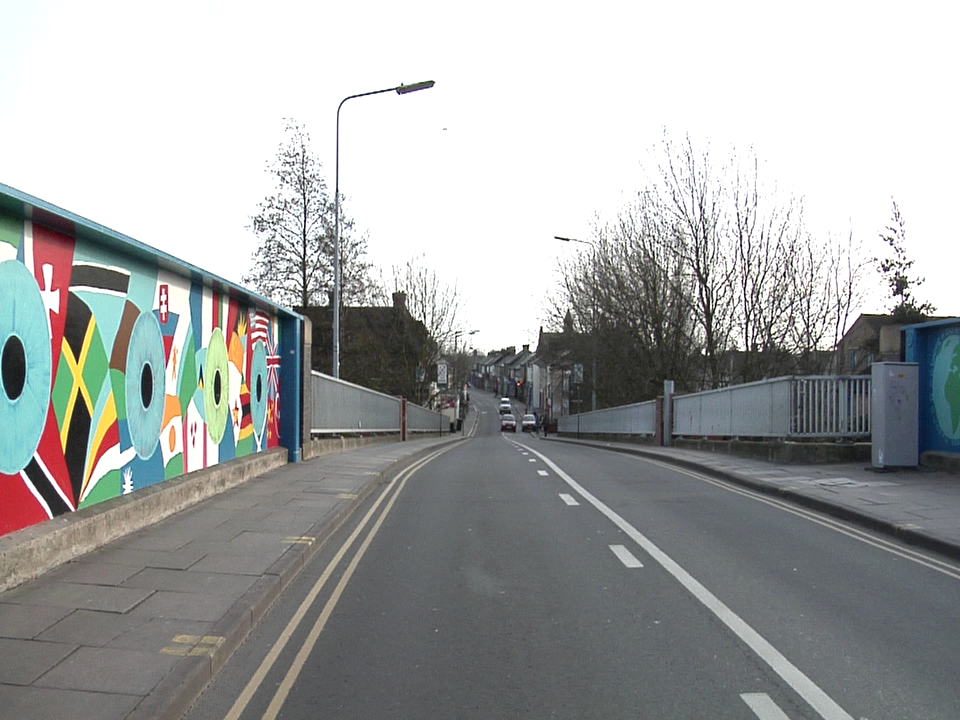

In [10]:
im = img_path.ls()[20]
fv.PILImage.create(im)

Con su respectiva etiqueta

In [11]:
labels_path.ls()

(#701) [Path('/home/.fastai/data/camvid/labels/Seq05VD_f04590_P.png'),Path('/home/.fastai/data/camvid/labels/0016E5_08085_P.png'),Path('/home/.fastai/data/camvid/labels/0016E5_06900_P.png'),Path('/home/.fastai/data/camvid/labels/0006R0_f02910_P.png'),Path('/home/.fastai/data/camvid/labels/0006R0_f00960_P.png'),Path('/home/.fastai/data/camvid/labels/Seq05VD_f01560_P.png'),Path('/home/.fastai/data/camvid/labels/0016E5_05220_P.png'),Path('/home/.fastai/data/camvid/labels/0016E5_04860_P.png'),Path('/home/.fastai/data/camvid/labels/0001TP_008250_P.png'),Path('/home/.fastai/data/camvid/labels/0001TP_010350_P.png')...]

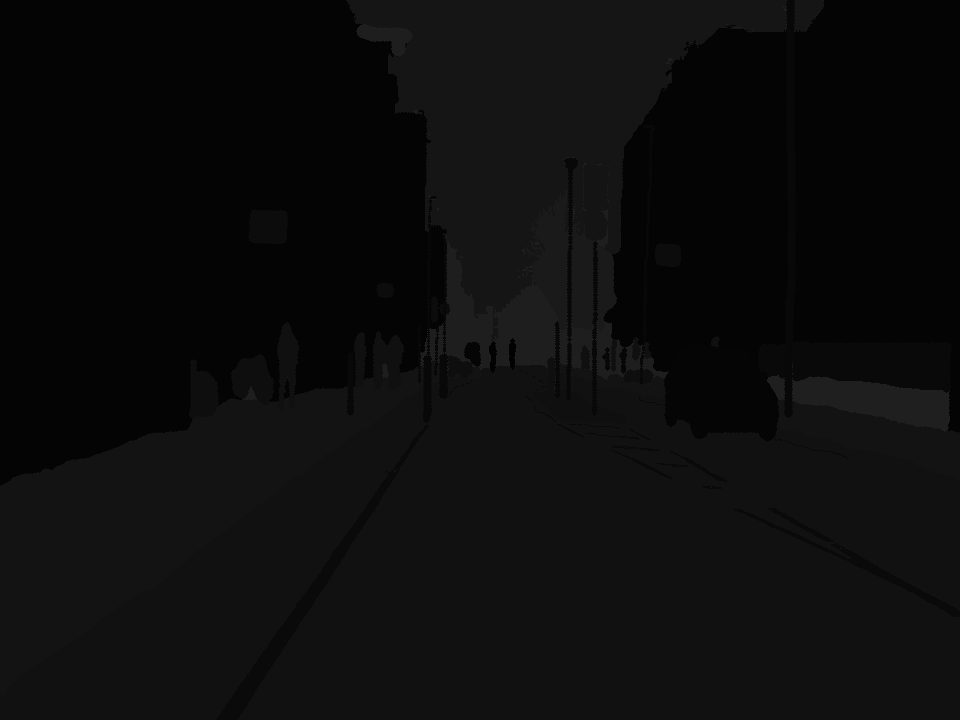

In [12]:
lbl = labels_path.ls()[20]
fv.PILImage.create(lbl)

Ahora hacemos la función para tomar una imagen y transformarla en su etiqueta. Esto lo hacemos para el get_y al crear el dataloader

In [13]:
def img2label(i):
    return i.parent.parent / "labels" / i.name.replace(".png","_P.png")

In [14]:
img2label(img_path.ls()[20])

Path('/home/.fastai/data/camvid/labels/Seq05VD_f03570_P.png')

Finalmente preparamos el conjunto de validación

In [15]:
valid_txt

Path('/home/.fastai/data/camvid/valid.txt')

In [16]:
validation_set = set()
with open(valid_txt, "r") as f:
    val = f.readlines()
    for v in val:
        validation_set.add(v.strip())
        print(v.strip())

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png
0016E5_07979.png
0016E5_07981.png
0016E5_07983.png
0016E5_07985.png
0016E5_07987.png
0016E5_07989.png
0016E5_07991.png
0016E5_07993.png
0016E5_07995.png
0016E5_07997.png
0016E5_07999.png
0016E5_08001.png
0016E5_08003.png
0016E5_08005.png
0016E5_08007.png
0016E5_08009.png
0016E5_08011.png
0016E5_08013.png
0016E5_08015.png
0016E5_08017.png
0016E5_08019.png
0016E5_08021.png
0016E5_08023.png
0016E5_08025.png
0016E5_08027.png
0016E5_08029.png
0016E5_08031.png
0016E5_08033.png
0016E5_08035.png
0016E5_08037.png
0016E5_08039.png
0016E5_08041.png
0016E5_08043.png
0016E5_08045.png
0016E5_08047.png
0016E5_08049.png
0016E5_08051.png
0016E5_08053.png
0016E5_08055.png
0016E5_08057.png
0016E5_08059.png
0016E5_08061.png
0016E5_08063.png
0016E5_08065.png
0016E5_08067.png
0016E5_08069.png
0016E5_08071.png
0016E5_08073.png
0016E5_08075.p

Con esto podemos crear nuestor dataloader

In [17]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size=img_size, # en segmentacion no es necesario hacer el data augmentation
                            do_flip=False,) 

    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.MaskBlock(codes=codes)), # el maskblock es el que se usa en segmentación. Por eso separamos todos los códigos que van de tener las imágenes dentro para segmentar
                        get_items = fv.get_image_files,
                        get_y     = img2label, # usamos la función que hicimos
                        splitter  = fv.FuncSplitter(lambda x: x.name in validation_set),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms = tfms
                        )
    
    return data.dataloaders(folder, batch_size=batch_size)

In [18]:
data = load_data(img_path, 512, 16)

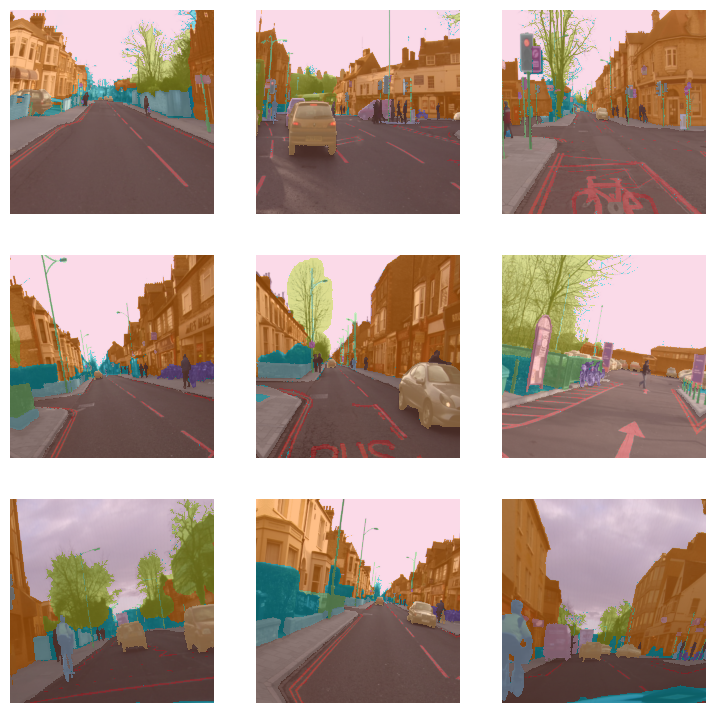

In [19]:
data.show_batch()

In [20]:
x, y = data.one_batch()

In [21]:
x.shape

torch.Size([16, 3, 512, 512])

In [22]:
y.shape

torch.Size([16, 512, 512])

Ahora vamos con la parte principal de la tarea: crear las métricas de accuracy.

Para empezar vamos a usar la accuracy completa para la segmentación que ya tenemos para todas las categorías

In [23]:
def seg_accuracy(yp, y):
    correct = (yp.argmax(dim=1) == y)
    return correct.float().mean()

Ahora preparamos la función de accuracy para peatones


In [33]:
codes.index("Pedestrian")

16

In [25]:
len(codes)

32

Nuestros tensores yp y y deben ser del tamaño del batch por 32 categorías y en cada una por la resolución de la imagen. Por lo que queremos únicamente el de la categoría 16 que es la de peatones

In [37]:
def pedestrian_accuracy(yp, y):
    predicciones = yp.argmax(dim=1)    # sacamos los resultados de la red neuronal de la segmentación
    seccionesConPeatones = (y == 16)   # sacamos los pixeles que sí tienen peatones de la imagen de referencia
    correct = (predicciones == y) & seccionesConPeatones  # sacamos de las categorías que sí se predijeron bien, las que son de peatones
    return correct.sum().float() / seccionesConPeatones.sum().float()

In [38]:
learn1 = fv.unet_learner(data, fv.resnet18,
                         opt_func=fv.ranger,
                         metrics=[seg_accuracy, pedestrian_accuracy]
                         ).to_fp16()

In [39]:
torch.cuda.empty_cache()

SuggestedLRs(valley=0.0002290867705596611)

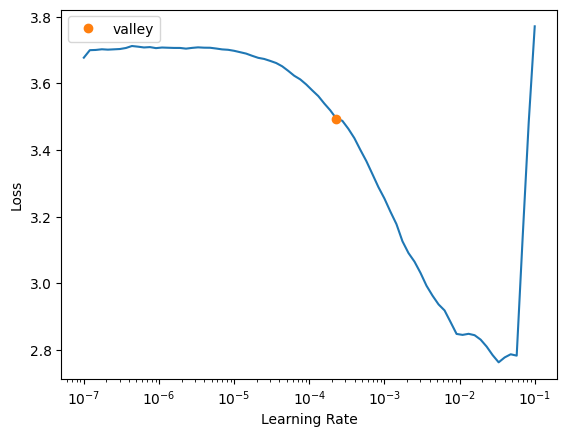

In [40]:
learn1.lr_find()

In [31]:
num_params(learn1)

31116008

In [41]:
learn1.fit_one_cycle(10, 0.001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,seg_accuracy,pedestrian_accuracy,time
0,1.935325,1.081122,0.729076,0.000000,00:25
1,1.260691,0.764842,0.801818,0.000026,00:25
2,0.914992,0.629821,0.827599,0.009828,00:25
3,0.754542,0.651598,0.816949,0.039607,00:25
4,0.670794,0.501931,0.856624,0.017035,00:25
5,0.616913,0.882321,0.744340,0.003365,00:25
6,0.562685,0.708227,0.805583,0.422043,00:25
7,0.625586,0.462992,0.860947,0.460959,00:25
8,0.536361,0.394106,0.876172,0.740339,00:25
9,0.468076,0.388587,0.875745,0.788246,00:25


Estos resultados son bastante raros: la parte de efectividad promedio al segmentar está bastante bien. Sin embargo, la forma en que evolucionó con los peatones fue sumamente extraño: duró 3 épocas en 0, otras 3 en menos del 3%, luego brincó arriba del 40% y cerró casi en 80%.

Esto puede tratarse porque los peatones son una categoría minoritaria que al inicio le costó mucho trabajo clasificar. En otras palabras, primero aprendió a identificar los objetos más comunes y finalmente a los más raros. Por lo que para esto puede que dar más épocas de entrenamiento es la solución

In [42]:
learn1.fit_one_cycle(10, 0.001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,seg_accuracy,pedestrian_accuracy,time
0,0.415340,0.376978,0.887276,0.769006,00:25
1,0.398052,0.368196,0.885469,0.752047,00:25
2,0.394190,0.384813,0.883090,0.824605,00:25
3,0.385567,0.337942,0.896923,0.758921,00:25
4,0.367015,0.351235,0.890466,0.896549,00:25
5,0.370921,0.381903,0.884511,0.832329,00:25
6,0.366810,0.375586,0.889150,0.650553,00:25
7,0.343074,0.296006,0.907880,0.885673,00:25
8,0.314113,0.283528,0.915447,0.813053,00:25
9,0.284969,0.296792,0.908725,0.853823,00:25


Esta práctica nos muestra algo muy importante cuando trabajamos con muchas categorías ya sea en segmentación, multiclasificación, etc: debemos contextualizar correctamente nuestro problema para saber qué métricas usar. 

Si esta red neuronal fuera para carros autónomos se tendría que priorizar la detección de peatones, caminos, semáforos, puentes, etc. Esto podría hacerse creando callbacks para guardar el modelo que funcione mejor para detectar ciertas categorías en una época. Por ejemplo: en este caso nos conviene guardar el modelo cuando tenga el accuracy más alto para los peatones. No nos sirve de mucho que alcance un accuracy muy alto gracias a las otras categorías si en la detección de peatones está con un 0%.